<h1 align= "center"> Multiclass Classifier Optimization and Comparison for Intrudsion Detection Systems in Cybersecurity <h1>

## SECTION 1: DECLARE THE MODULES

In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#!pip install wget
import wget

from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
np.set_printoptions(suppress=True) 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint,reciprocal, uniform
#!pip install lightgbm
import lightgbm as lgb
#!pip install hyperopt
from hyperopt import hp 
import hyperopt.pyll
from hyperopt.pyll import scope
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.metrics import plot_confusion_matrix
#!pip install yellowbrick
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ROCAUC

# SECTION 2: Data Import 

In [2]:
link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data) 
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

100% [..................................................................................] 500 / 500

# SECTION 3: Data Pre-Processing 

In [3]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

# training_attack_types.txt maps each of the 40 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()


# training_attack_types.txt maps each of the 40 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [4]:
#Processing Training Data

train_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'



train_df = pd.read_csv(train_file, names=header_names)


train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])

train_df.drop(['success_pred'], axis=1, inplace=True)

#Processing test Data
test_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)


train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()


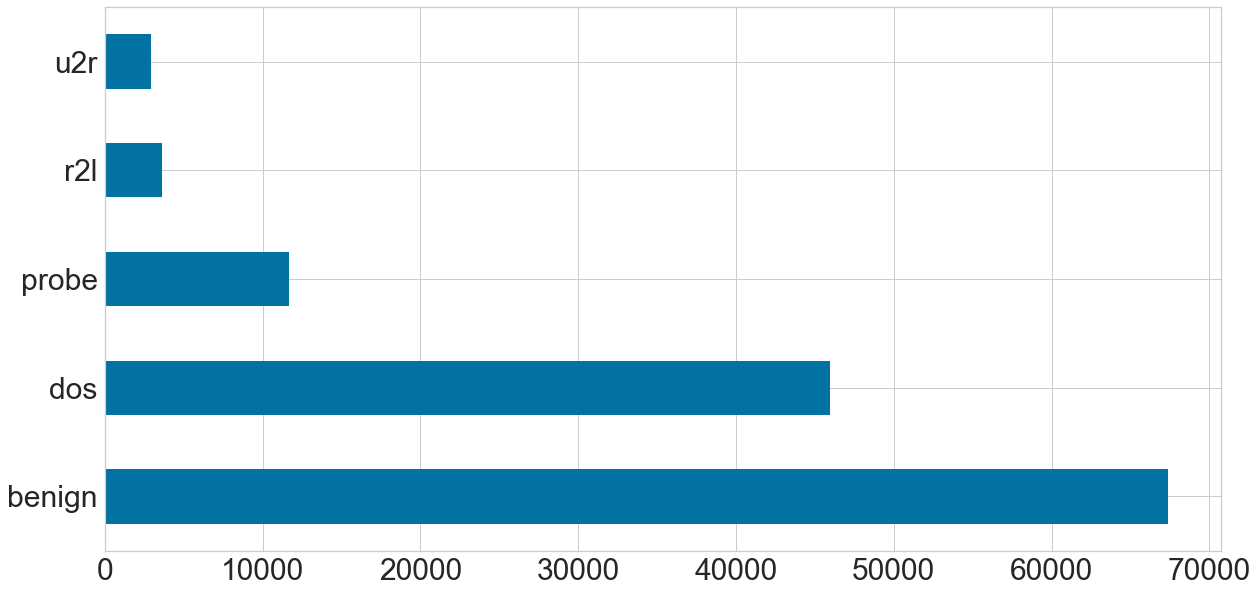

In [5]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
train_df.groupby(['num_outbound_cmds']).size()

#Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')



#Data Preparation

train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

#execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    
train_x.describe()



train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)


# SECTION 4: Data Exploration

In [6]:
#identifying attribute names
print("Attribute Names \t\t Data Type\n")
train_df.dtypes

Attribute Names 		 Data Type



duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate                float64
rerror_rate              

In [7]:
#checking the length of train and test dataset
print("Length of Train Dataset:",len(train_df))
print("Length of Test Dataset:",len(test_df))

Length of Train Dataset: 125973
Length of Test Dataset: 22544


In [8]:
#Checking the total number of samples that belong to each class of the train dataset
print("Number of samples in each five classes of train dataset \n",train_attack_cats)

Number of samples in each five classes of train dataset 
 benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_category, dtype: int64


In [9]:
#Checking the total number of samples that belong to each class of the test dataset
print("Number of samples in each five classes of test dataset \n",test_attack_cats)

Number of samples in each five classes of test dataset 
 benign    9711
dos       7636
r2l       2574
probe     2423
u2r        200
Name: attack_category, dtype: int64


# SECTION 6: Multi class classification

## 1. Decision Tree

Decision Tree is one of the popular and most widely used Machine Learning Algorithms because of its robustness to noise, tolerance against missing information, handling of irrelevant, redundant predictive attribute values, low computational cost, interpretability, fast run time and robust predictors. A Decision Tree is constructed by asking a serious of questions with respect to a record of the dataset we have got. Each time an answer is received, a follow-up question is asked until a conclusion about the class label of the record. In a decision tree, each leaf node is assigned a class label. The non-terminal nodes, which include the root and other internal nodes, contain attribute test conditions to separate records that have different characteristics.

### Before Optimization

In [10]:
dec_tree = DecisionTreeClassifier(random_state =0)
dec_tree.fit(train_x, train_Y)

pred_y = dec_tree.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)


print("Confusion Matrix: \n", results )
print("\n Error:", error)
print("\n Accuracy:", accuracy_score(pred_y,test_Y))

Confusion Matrix: 
 [[9438   60  209    4    0]
 [1419 6118   99    0    0]
 [ 672  217 1534    0    0]
 [2317    4   15  233    5]
 [ 177    0    2    6   15]]

 Error: 0.23092618878637328

 Accuracy: 0.7690738112136267


### Tuning hyperparameters using random search and fitting the model with optimized algorithm

In [11]:
#Tuning Hyperparameters using RandomizedSearchCV
"""parameters = {"criterion" : ['gini', 'entropy'],'max_depth' : [3,None] , "min_samples_leaf": randint(1,20), 'min_samples_split' : randint(2,40)}
for i in tqdm(range(0,1)):
    opt_dec_tree = RandomizedSearchCV(tree, parameters, cv = 5, n_iter=10, n_jobs=-1, verbose=0)
    opt_dec_tree.fit(train_x,train_Y)
    pred_y = opt_dec_tree.predict(test_x)

print("Optimized classifier:", opt_dec_tree.best_estimator_)
print("best Score:", opt_dec_tree.best_score_)
print("\nAccuracy in test data:", accuracy_score(test_Y,pred_y))"""

#Fitting the optimized algorithm
for i in tqdm(range(0,1)):
    tree = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, min_samples_split= 5, random_state = 0)
    tree.fit(train_x,train_Y)
    pred_y = tree.predict(test_x)

results_tree = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


### Model Performance

In [12]:
print(" Confusion Matrix of optimized Decision Tree: \n", results_tree )
print("\n Error after optimization:", error)
print("\n Accuracy after optimization:", accuracy_score(test_Y,pred_y))
print("\n Model Performance: \n",classification_report(test_Y, pred_y))

#Calulating various performance metrics from confusion matrix
FP = results_tree.sum(axis=0) - np.diag(results_tree)
FN = results_tree.sum(axis=1) - np.diag(results_tree)
TP = np.diag(results_tree)
TN = results_tree.sum() - (FP + FN + TP)
# Accuracy of each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("\n\t    Benign \tdos \t   probe \tr2l \t  u2r \n")
print("Accuracy", ACC)
#True Positive Rate of each class
TPR = TP/(TP+FN)
TPR = TPR.astype(float)
print("TPR     ",TPR)
#True Negative Rate of each class
TNR = TN/(TN+FP) 
TNR = TNR.astype(float)
print("TNR     ",TNR)
#False Positive Rate of each class
FPR = FP/(FP+TN)
FPR = FPR.astype(float)
print("FPR     ", FPR)
# False negative rate of each class
FNR = FN/(TP+FN)
print("FNR     ",FNR)

 Confusion Matrix of optimized Decision Tree: 
 [[9431   60  218    2    0]
 [1416 6124   96    0    0]
 [ 686  216 1521    0    0]
 [2282    0   11  277    4]
 [ 175    0    3    6   16]]

 Error after optimization: 0.22955110007097235

 Accuracy after optimization: 0.7704488999290277

 Model Performance: 
               precision    recall  f1-score   support

      benign       0.67      0.97      0.80      9711
         dos       0.96      0.80      0.87      7636
       probe       0.82      0.63      0.71      2423
         r2l       0.97      0.11      0.19      2574
         u2r       0.80      0.08      0.15       200

    accuracy                           0.77     22544
   macro avg       0.85      0.52      0.54     22544
weighted avg       0.82      0.77      0.74     22544


	    Benign 	dos 	   probe 	r2l 	  u2r 

Accuracy [0.78535309 0.92068843 0.94544003 0.8977555  0.99166075]
TPR      [0.97116672 0.80199057 0.62773421 0.10761461 0.08      ]
TNR      [0.64474402 0.9814

## 2. SVM
Support Vector Machine is a supervised classification algorithm that works based on the concept of hyper planes that define decision boundaries. A decision-plane/hyperplane separates a set of objects that belong to different classes. In the SVM algorithm, each record in the dataset is plotted as a point in n-dimensional space, where n is number of attributes in the dataset. The co-ordinates of the point are actually the values of each of the attributes. Then, classification is attempted by trying to find the hyperplane that best differentiates all the data points plotted into different classes with the help of support vectors.

### Before Optimization

In [13]:
for i in tqdm(range(0,1)):
    svc_svm = SVC(random_state=0) 
    svc_svm.fit(train_x,train_Y)
    y_pred = svc_svm.predict(test_x)

error = zero_one_loss(test_Y, y_pred)

print("Confusion Matrix: \n",confusion_matrix(test_Y, y_pred))
print("\n Error: ", error)
print("\n Acuuracy: ", accuracy_score(y_pred, test_Y))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.99s/it]

Confusion Matrix: 
 [[9462   62  187    0    0]
 [1882 5693   61    0    0]
 [ 836  175 1412    0    0]
 [2318    0    4  252    0]
 [ 177    0   15    3    5]]

 Error:  0.2537260468417317

 Acuuracy:  0.7462739531582683


### Tuning hyperparameters using random search and fitting the model with optimized algorithm

In [14]:
# Tuning Hyperparameters using RandomizedSearchCV
"""parameters = {'kernel':['linear', 'rbf', 'poly'], 'C': uniform(0.1, 100.0)}
for i in tqdm(range(0,1)):
    opt_svm = RandomizedSearchCV(svc_svm, parameters, cv = 5,n_iter=10, n_jobs=-1, verbose=0)
    opt_svm.fit(train_x,train_Y)
    pred_y = opt_svm.predict(test_x)

print("Optimized classifier:", opt_svm.best_estimator_)
print("best Score:", opt_svm.best_score_)
print("\nAccuracy in test data:", accuracy_score(test_Y,pred_y))"""

#Fitting the optimized algorithm
for i in tqdm(range(0,1)):
    svm = SVC(kernel='linear',C = 100, random_state=0) 
    svm.fit(train_x,train_Y)
    y_pred = svm.predict(test_x)

results_svm = confusion_matrix(test_Y, y_pred)
error = zero_one_loss(test_Y, y_pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [14:20<00:00, 860.88s/it]


### Model Performance

In [15]:
print("Confusion Matrix of Optimized SVM \n",results_svm)
print("\n Error after optimization", error)
print("\n Accuracy after optimization", accuracy_score(y_pred, test_Y))
print("\n Model Performance: \n", classification_report(test_Y, y_pred))

#Calulating various performance metrics from confusion matrix
FP = results_svm.sum(axis=0) - np.diag(results_svm)
FN = results_svm.sum(axis=1) - np.diag(results_svm)
TP = np.diag(results_svm )
TN = results_svm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Accuracy of each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("\t    Benign \tdos \t   probe \tr2l \t  u2r \n")
print("Accuracy", ACC)
#True Positive Rate of each class
TPR = TP/(TP+FN)
TPR = TPR.astype(float)
print("TPR     ",TPR)
#True Negative Rate of each class
TNR = TN/(TN+FP) 
TNR = TNR.astype(float)
print("TNR     ",TNR)
#False Positive Rate
FPR = FP/(FP+TN)
FPR = FPR.astype(float)
print("FPR     ", FPR)
# False negative rate
FNR = FN/(TP+FN)
print("FNR     ",FNR)

Confusion Matrix of Optimized SVM 
 [[9117  400  183    6    5]
 [1714 5892   30    0    0]
 [ 637   93 1693    0    0]
 [2280    0    2  288    4]
 [ 177    1    2    7   13]]

 Error after optimization 0.24578601845280346

 Accuracy after optimization 0.7542139815471965

 Model Performance: 
               precision    recall  f1-score   support

      benign       0.65      0.94      0.77      9711
         dos       0.92      0.77      0.84      7636
       probe       0.89      0.70      0.78      2423
         r2l       0.96      0.11      0.20      2574
         u2r       0.59      0.07      0.12       200

    accuracy                           0.75     22544
   macro avg       0.80      0.52      0.54     22544
weighted avg       0.80      0.75      0.72     22544

	    Benign 	dos 	   probe 	r2l 	  u2r 

Accuracy [0.7603797  0.90072747 0.95799326 0.89802165 0.99130589]
TPR      [0.93883225 0.77160817 0.69872059 0.11188811 0.065     ]
TNR      [0.62534092 0.96686343 0.98921525

## 3. LR
Logistic Regression classifier is a predictive analysis algorithm based on the concept of probability. It can only be used when the target variables are discrete/categorical. When using logistic regression, a threshold must be specified based on which the algorithm can decide whether to put a value into one class or the other.Logistic Regression is actually a Linear Regression model with more complex cost function, known as the ‘Sigmoid function’.The objective of the algorithm is to  minimize  the cost function so that accuracy will be maximized.  To minimize the cost function, a gradient descent function is run on each parameter.

### Before Optimization

In [16]:
for i in tqdm(range(0,1)):
    lr = LogisticRegression()
    lr.fit(train_x, train_Y)
    y_pred = lr.predict(test_x)

error = zero_one_loss(test_Y, y_pred)

print("Confusion Matrix : \n", confusion_matrix(test_Y, y_pred))
print("\n Accuracy :", accuracy_score(y_pred, test_Y))
print("\n Error :", error)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]

Confusion Matrix : 
 [[8993   90  624    2    2]
 [1560 6052   24    0    0]
 [ 496   99 1825    3    0]
 [2471    2    2   99    0]
 [ 184    3    0    5    8]]

 Accuracy : 0.7530606813342796

 Error : 0.2469393186657204


### Tuning hyperparameters using random search and fitting the model with optimized algorithm

In [17]:
#Tuning Hyperparameters using RandomizedSearchCV
"""
#defining search space
parameters = {'penalty' : ['l1', 'l2','elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
    
#Building a 5 fold RandomizedSearchCV 
rand_lr = RandomizedSearchCV(lr, parameters, cv = 5)

#Fitting the random search to the training data
rand_lr.fit(train_x, train_Y)

#Extracting the best parameters
print("Best Parameters:",rand.best_params_) 
print("Best Estimator:",rand.best_estimator_)""" 

#Fitting the optimized algorithm
for i in tqdm(range(0,1)):
    lr = LogisticRegression(C=0.1, penalty='none', solver='newton-cg', class_weight='balanced')
    lr.fit(train_x, train_Y)
    pred_y = lr.predict(test_x)

results_lr = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [10:56<00:00, 656.30s/it]


### Model Performance

In [18]:
print("Confusion Matrix : \n", results_lr)
print("\n Accuracy after optimization", accuracy_score(pred_y, test_Y))
print("\n Error after optimization", error)
print("\n Model Performance: \n",classification_report(test_Y, pred_y))

#Calulating various performance metrics from confusion matrix
FP = results_lr.sum(axis=0) - np.diag(results_lr )
FN = results_lr.sum(axis=1) - np.diag(results_lr )
TP = np.diag(results_lr )
TN = results_lr.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Accuracy of each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("\t    Benign \tdos \t   probe \tr2l \t  u2r \n")
print("Accuracy", ACC)
#True Positive Rate of each class
TPR = TP/(TP+FN)
TPR = TPR.astype(float)
print("TPR     ",TPR)
#True Negative Rate of each class
TNR = TN/(TN+FP) 
TNR = TNR.astype(float)
print("TNR     ",TNR)
#False Positive Rate
FPR = FP/(FP+TN)
FPR = FPR.astype(float)
print("FPR     ", FPR)
# False negative rate
FNR = FN/(TP+FN)
print("FNR     ",FNR)

Confusion Matrix : 
 [[8887   58  701   36   29]
 [1682 5929   21    0    4]
 [ 227  150 1951   46   49]
 [1720    2   25  484  343]
 [ 139    0    0   36   25]]

 Accuracy after optimization 0.7663236337828248

 Error after optimization 0.23367636621717525

 Model Performance: 
               precision    recall  f1-score   support

      benign       0.70      0.92      0.79      9711
         dos       0.97      0.78      0.86      7636
       probe       0.72      0.81      0.76      2423
         r2l       0.80      0.19      0.30      2574
         u2r       0.06      0.12      0.08       200

    accuracy                           0.77     22544
   macro avg       0.65      0.56      0.56     22544
weighted avg       0.80      0.77      0.75     22544

	    Benign 	dos 	   probe 	r2l 	  u2r 

Accuracy [0.79630944 0.91496629 0.94592796 0.9020582  0.97338538]
TPR      [0.91514777 0.77645364 0.80520017 0.18803419 0.125     ]
TNR      [0.70638198 0.9859136  0.96287461 0.99409114 0.9

## 4. MLP
MLP is a commonly used artificial neural network built out of artificial neurons. An artificial neuron simple computational unit that weigh input signals and produce an output signal utilizing an activation function.An MLP learns to model the correlation of input-output pairs by changing the connection weights after each packet of data is processed and compares the amount of error in the output to the expected result.This supervised learning is carried out through backpropagation which is a generalization of the least mean squares algorithm in the linear perceptron, and trains by adjusting the parameters,  weights and biases of the model to minimize the error.

### Before Optimization

In [19]:
for i in tqdm(range(0,1)):
    Mlp = MLPClassifier(random_state=1)
    Mlp.fit(train_x, train_Y)
    y_pred = Mlp.predict(test_x)

error = zero_one_loss(test_Y, y_pred)

print("Confusion Matrix: \n",confusion_matrix(test_Y, y_pred))
print("Accuracy", accuracy_score(y_pred, test_Y))
print("Error: ", error)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:49<00:00, 169.50s/it]

Confusion Matrix: 
 [[8988  401  319    2    1]
 [1390 6142  104    0    0]
 [ 651  311 1461    0    0]
 [2053   73   30  417    1]
 [ 171    0    8   12    9]]
Accuracy 0.7548349893541518
Error:  0.24516501064584817


### Tuning hyperparameters using random search and fitting the model with optimized algorithm

In [20]:
#Tuning Hyperparameters using RandomizedSearchCV
"""params = {'hidden_layer_sizes':[(10,),(20,),(30,),(100,)],
               'alpha':uniform(0.0001,0.05),
               'activation': [‘identity’, ‘logistic’, ‘tanh’, ‘relu’],
               'solver': [‘lbfgs’, ‘sgd’, ‘adam’]}

mlp_rand = RandomizedSearchCV(MLPClassifier(random_state =1), parameters, cv = 5, n_iter=10, n_jobs=-1, verbose=0)
mlp_rand.fit(train_x,train_Y)
pred_y = mlp_rand.predict(test_x)

print('Best Model : ',mlp_grid.best_estimator_)
print('Accuracy :', accuracy_score(test_Y,pred_y))
print("Confusion Matrix",confusion_matrix(test_Y, pred_y))"""

#Fitting the optimized algorithm
for i in tqdm(range(0,1)):
    mlp = MLPClassifier(hidden_layer_sizes = (20,), alpha = 0.0001, random_state=1)
    mlp.fit(train_x,train_Y)
    y_pred = mlp.predict(test_x)

error = zero_one_loss(test_Y, y_pred)
results_mlp = confusion_matrix(test_Y, y_pred)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:48<00:00, 108.13s/it]


### Model Performance

In [21]:
print("Confusion Matrix: \n", results_mlp)
print("\n Accuracy after optimization: ", accuracy_score(y_pred, test_Y))
print("\n Error: ", error)
print("\n Model Performance: \n", classification_report(test_Y, y_pred))

#Calulating various performance metrics from confusion matrix
FP = results_mlp.sum(axis=0) - np.diag(results_mlp)
FN = results_mlp.sum(axis=1) - np.diag(results_mlp)
TP = np.diag(results_mlp)
TN = results_mlp.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Accuracy of each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("\t    Benign \tdos \t   probe \tr2l \t  u2r \n")
print("Accuracy", (ACC))
#True Positive Rate of each class
TPR = TP/(TP+FN)
TPR = TPR.astype(float)
print("TPR     ",TPR)
#True Negative Rate of each class
TNR = TN/(TN+FP) 
TNR = TNR.astype(float)
print("TNR     ",TNR)
#False Positive Rate
FPR = FP/(FP+TN)
FPR = FPR.astype(float)
print("FPR     ", FPR)
# False negative rate
FNR = FN/(TP+FN)
print("FNR     ", FNR)

Confusion Matrix: 
 [[9431   54  221    2    3]
 [1227 6123   73  213    0]
 [ 385  166 1863    9    0]
 [1923    0   11  638    2]
 [ 166    1    4   12   17]]

 Accuracy after optimization:  0.8016323633782825

 Error:  0.19836763662171752

 Model Performance: 
               precision    recall  f1-score   support

      benign       0.72      0.97      0.83      9711
         dos       0.97      0.80      0.88      7636
       probe       0.86      0.77      0.81      2423
         r2l       0.73      0.25      0.37      2574
         u2r       0.77      0.09      0.15       200

    accuracy                           0.80     22544
   macro avg       0.81      0.57      0.61     22544
weighted avg       0.82      0.80      0.78     22544

	    Benign 	dos 	   probe 	r2l 	  u2r 

Accuracy [0.82341199 0.92308375 0.96145316 0.90365507 0.99166075]
TPR      [0.97116672 0.80185961 0.76888155 0.24786325 0.085     ]
TNR      [0.7116029  0.98517574 0.98464291 0.98818227 0.99977623]
FPR    

## 5. Light Gradient Boost
Gradient boosted machine is another boosting algorithm based on ensemble approach. It’s mostly built on decision trees to increase the efficiency while reducing memory usage. Arbitrary differentiable loss function and gradient descent optimization algorithm are used to fit the model and the best model will have minimum loss gradient. LGBM is a leaf-wise tree splitting algorithm on contrary to the usual level-wise splitting tree-based algorithms and hence has better accuracy.

### Before optimization

In [25]:
for i in tqdm(range(0,1)):
    lgm = lgb.LGBMClassifier(random_state=3)
    lgm.fit(train_x,train_Y)
    pred_y = lgm.predict(test_x)

error = zero_one_loss(test_Y, pred_y)


print("Confusion Matrix : \n", confusion_matrix(test_Y, pred_y))
print("\n Accuracy :", accuracy_score(pred_y, test_Y))
print("\n Error : ", error)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.39s/it]

Confusion Matrix : 
 [[8887   75  694   17   38]
 [1761 5528  344    3    0]
 [ 516  235 1640   28    4]
 [2315    7   23  210   19]
 [ 168   10    7    5   10]]

 Accuracy : 0.7219215755855216

 Error :  0.2780784244144784


### Tuning hyperparameters using bayesian optimization hyperopt and fitting the model with optimized algorithm

In [26]:
#Optimizing hyperparameters using hyperopt
"""param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 5, 35, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0)}


def hyperopt(param_space, trainx, trainY, testx, testY, num_eval):
        
    def objective_function(params):
        clf = lgb.LGBMClassifier(**params)
        score = cross_val_score(clf, trainx, trainY, cv=5).mean()
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval,trials=trials,rstate= np.random.RandomState(0))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    if best_param_values[0] == 0:
        boosting_type = 'gbdt'
    else:
        boosting_type= 'dart'
    
    clf_best = lgb.LGBMClassifier(learning_rate=best_param_values[2],
                                  num_leaves=int(best_param_values[5]),
                                  max_depth=int(best_param_values[3]),
                                  n_estimators=int(best_param_values[4]),
                                  boosting_type=boosting_type,
                                  colsample_bytree=best_param_values[1],
                                  reg_lambda=best_param_values[6],
                                 )
                                  
    clf_best.fit(trainx, trainY)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", clf_best.score(test_x, test_Y))
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

num_eval = 100
results_hyperopt = hyperopt(param_hyperopt, train_x, train_Y, test_x, test_Y, num_eval)"""

#Fitting the optimized algorithm
for i in tqdm(range(0,1)):
    lgb_best = lgb.LGBMClassifier(boosting_type= 'gbdt', colsample_bytree= 0.9415752701215474, learning_rate= 0.4663399671202301, max_depth = 8, n_estimators= 35, num_leaves= 46, reg_lambda= 0.7713266499833298, random_state=3)
    lgb_best.fit(train_x, train_Y)
    pred_y = lgb_best.predict(test_x)

results_lgb = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


### Model Performance

In [27]:
print("Confusion Matrix : \n", results_lgb)
print("\n Accuracy after optimization : ", accuracy_score(test_Y,pred_y))
print("\n Error after optimization : ", error)
print("\n Model Performance: \n", classification_report(test_Y, pred_y))

#Calulating various performance metrics from confusion matrix
FP = results_lgb.sum(axis=0) - np.diag(results_lgb)
FN = results_lgb.sum(axis=1) - np.diag(results_lgb)
TP = np.diag(results_lgb )
TN = results_lgb.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Accuracy of each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print("\t    Benign \tdos \t   probe \tr2l \t  u2r \n")
print("Accuracy", ACC)
#True Positive Rate of each class
TPR = TP/(TP+FN)
TPR = TPR.astype(float)
print("TPR     ",TPR)
#True Negative Rate of each class
TNR = TN/(TN+FP) 
TNR = TNR.astype(float)
print("TNR     ",TNR)
#False Positive Rate
FPR = FP/(FP+TN)
FPR = FPR.astype(float)
print("FPR     ", FPR)
# False negative rate
FNR = FN/(TP+FN)
print("FNR     ",FNR)

Confusion Matrix : 
 [[9433   67  205    3    3]
 [1462 6073  101    0    0]
 [ 530  163 1730    0    0]
 [1654    0    1  912    7]
 [ 182    0    0    3   15]]

 Accuracy after optimization :  0.8056689141234918

 Error after optimization :  0.19433108587650816

 Model Performance: 
               precision    recall  f1-score   support

      benign       0.71      0.97      0.82      9711
         dos       0.96      0.80      0.87      7636
       probe       0.85      0.71      0.78      2423
         r2l       0.99      0.35      0.52      2574
         u2r       0.60      0.07      0.13       200

    accuracy                           0.81     22544
   macro avg       0.82      0.58      0.62     22544
weighted avg       0.84      0.81      0.79     22544

	    Benign 	dos 	   probe 	r2l 	  u2r 

Accuracy [0.81786728 0.92046664 0.9556423  0.92601136 0.99135025]
TPR      [0.97137267 0.79531168 0.71399092 0.35431235 0.075     ]
TNR      [0.70170654 0.98457204 0.98474231 0.999699

# Section 7: Data Visualization

### Confusion Matrix

#### Decision Tree

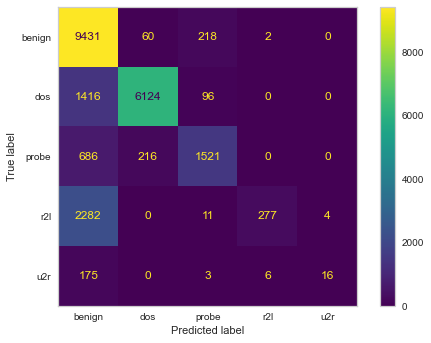

In [28]:
plot_confusion_matrix(tree,test_x,test_Y)
plt.grid(False)
plt.show()

#### Support Vector Machines

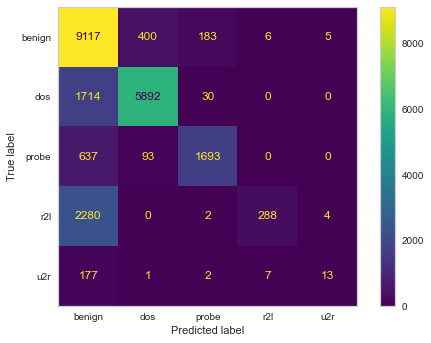

In [29]:
plot_confusion_matrix(svm,test_x,test_Y)
plt.grid(False)
plt.show()

#### Logistic Regression

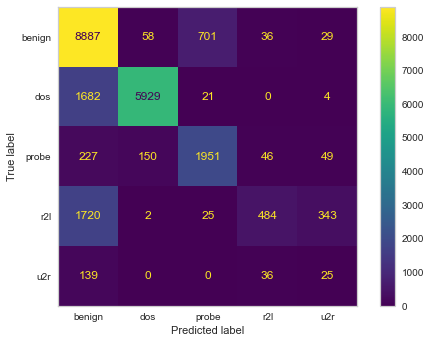

In [30]:
plot_confusion_matrix(lr,test_x,test_Y)
plt.grid(False)
plt.show()

#### Multi Layer Perceptron

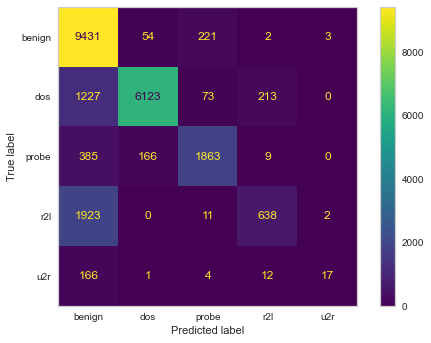

In [31]:
plot_confusion_matrix(mlp,test_x,test_Y)
plt.grid(False)
plt.show()

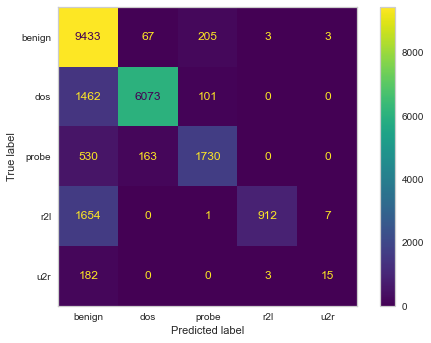

In [33]:
plot_confusion_matrix(lgb_best,test_x,test_Y)
plt.grid(False)
plt.show()

### Classification Report

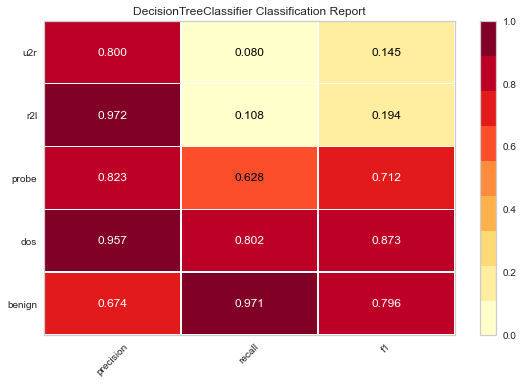

In [34]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer=ClassificationReport(tree,classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.poof()

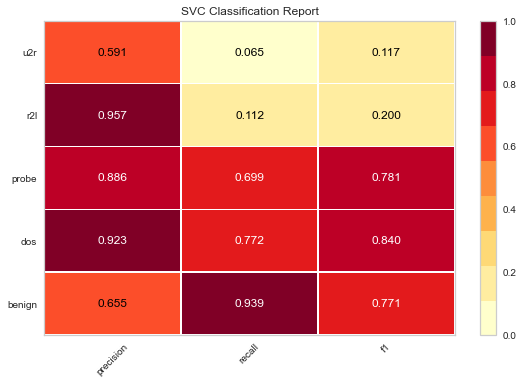

In [35]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer=ClassificationReport(svm,classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.poof()

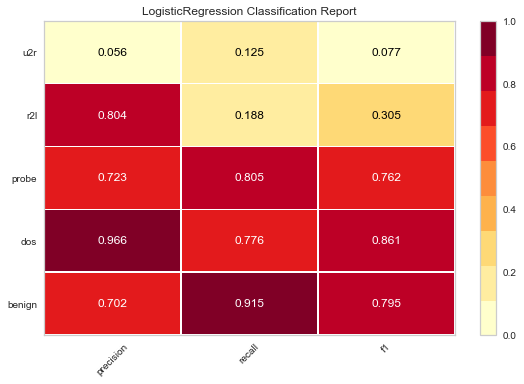

In [36]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer=ClassificationReport(lr,classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.poof()

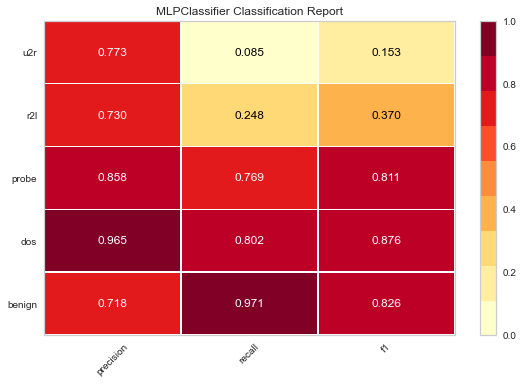

In [37]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer=ClassificationReport(mlp,classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.poof()

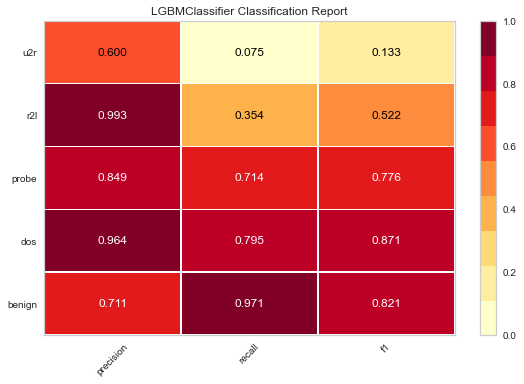

In [39]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer=ClassificationReport(lgb_best,classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.poof()

### Class Prediction Error

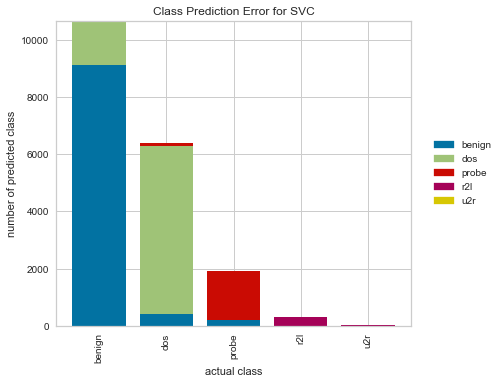

In [41]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ClassPredictionError(svm, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

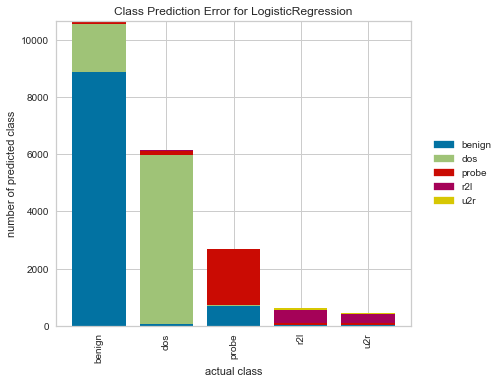

In [42]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ClassPredictionError(lr, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

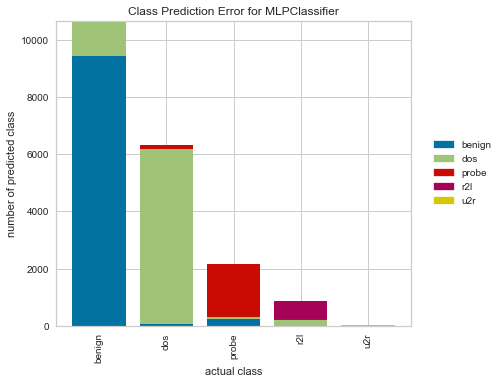

In [43]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ClassPredictionError(mlp, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

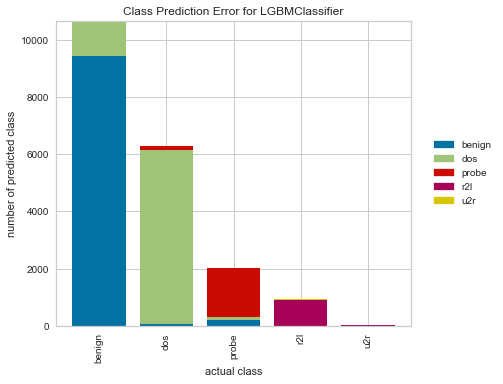

In [45]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ClassPredictionError(lgb_best, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

### ROC Curves

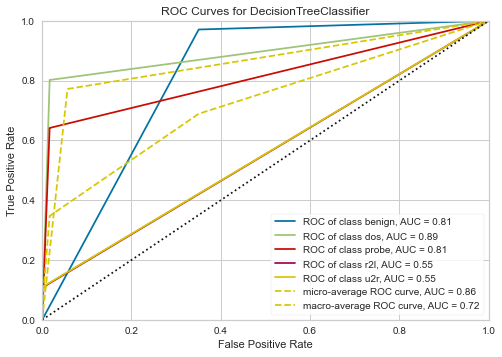

In [46]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ROCAUC(tree, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

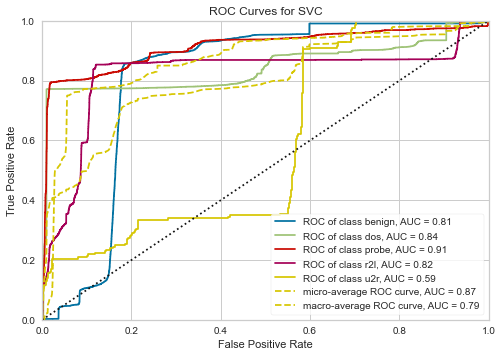

In [47]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ROCAUC(svm, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

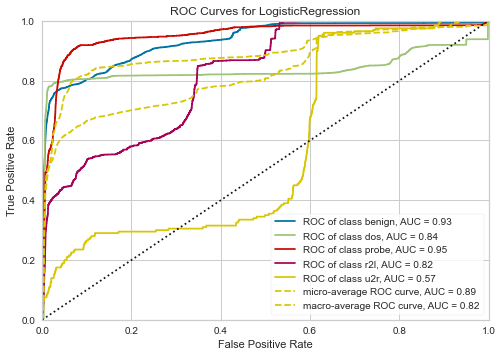

In [48]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ROCAUC(lr, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

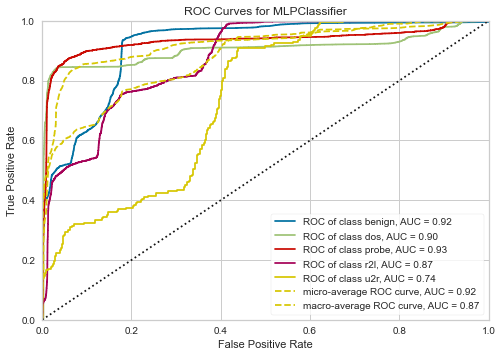

In [49]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ROCAUC(mlp, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

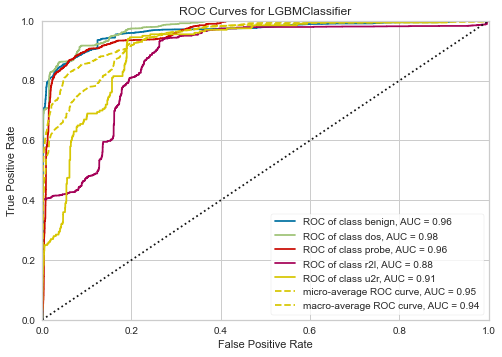

In [51]:
classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']
visualizer = ROCAUC(lgb_best, classes=classes)
visualizer.fit(train_x, train_Y)
visualizer.score(test_x, test_Y)
visualizer.show()

## Comparison of all models using Barchart

### Accuracy and Precision

In [58]:
import pandas as pd
path = "https://raw.githubusercontent.com/V-Anon/SIT719/main/summary_model.csv"
summary = pd.read_csv(path)
summary.set_index("Algorithm", inplace=True)
summary

,Precision,Recall,F-score,Accuracy
Algorithm,,,,
DT,0.82,0.77,0.74,0.77
SVM,0.80,0.75,0.72,0.75
LR,0.80,0.77,0.75,0.77
MLP,0.82,0.80,0.78,0.80
LGBM,0.84,0.81,0.79,0.81


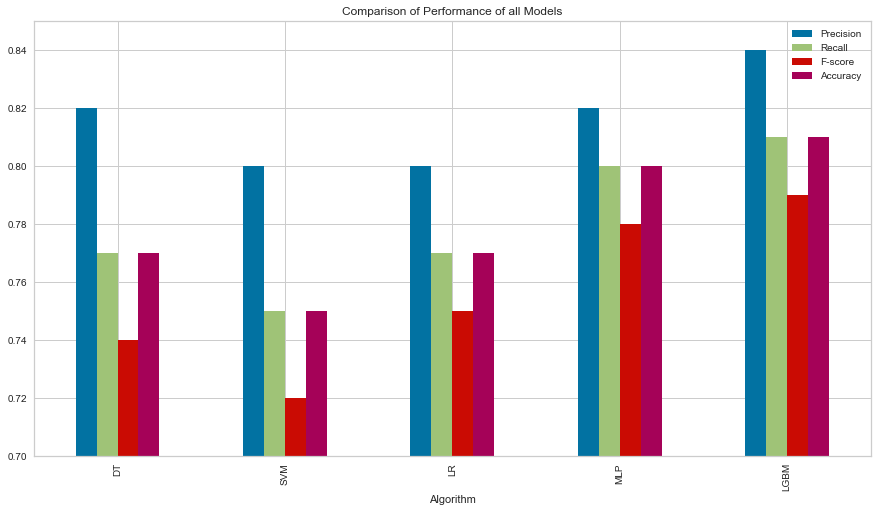

In [59]:
summary.plot.bar(figsize = (15,8), title = "Comparison of Performance of all Models", ylim = (0.7,0.85))